## Table of Contents

- [B6 Digital Twins](#B6-Digital-Twins)
  - [6.1 User Story 1](#6.1-User-Story-1)
  - [6.2 User Story 2](#6.2-User-Story-2)
- [🏠 Home](../../welcomePage.ipynb)

# B6 Digital Twins
As introduced at the Green Belt level, constructing a digital twin requires a structured approach involving specific techniques and sequential steps. This section provides a detailed overview, accompanied by relevant code examples, to illustrate the implementation of digital twin technology.

## 6.1 User Story 1
**Additive Scanning Subtractive**
### <font color = '#646464'>6.1.1 Preliminary definitions</font>


<img src="Module 6 Content/A_S_S_1.png" alt="Drawing" style="width: 600px;" title="1"/>


### <font color = '#646464'>6.1.2 Variables</font>
* MaxCuttingDepth: The closest we allow the cutting tool to the printing bed in mm
* PassDepth: The depth of one cutting pass per revovlution in mm
* FeedRate: The traveling speed of the cutting tool in mm/min
* ToolThreeStartingLocation: The reference point of tool 3's starting location (X in mm, Y in mm)
* Scale_factor: The scaling factor in percentage of original stl file compared to printed part
* PixelsToFill: The amount of absent pixels to fill when processing scanner data
* scannerResolution: The dimensions of each individual pixel in the scanner data in mm
* ToolRadius: The radius of the cutting tool in mm
* ToolClearenceHeight: Distance to lower printing bed durring cutting tool entry and exit in mm
* ScanningClearence: The Z-axis offset from scanner to produce accurate scans in mm
* SearchRadius: The distance from currently selected reference point to search for new line segments to generate cutting path in mm

##### **File Path's**
* Location's for each file to download and upload data to the printer, scanner, and data processing functions.

##### **Press ▶️ to call the required Python libraries and add the file path**

In [1]:
import numpy as np
from typing import List, Tuple
import math
import pandas as pd
import csv

import trimesh
import trimesh.path

from shapely.geometry import Polygon, MultiPolygon, GeometryCollection, MultiLineString, Point, CAP_STYLE, JOIN_STYLE, LineString, LinearRing
from shapely.ops import linemerge, unary_union, transform
from shapely.affinity import rotate

import plotly.express as px
import plotly.graph_objects as go

import matplotlib.pyplot as plt

from scipy.ndimage import find_objects, binary_erosion, label, binary_dilation
from scipy.ndimage import binary_fill_holes

from skimage.measure import find_contours
from skimage import measure

from sympy import Point 

import requests
import logging
import subprocess
import os
import time

MaxCuttingDepth = 1 #The closest we allow the cutting tool to the printing bed in mm
PassDepth = 3 #The depth of one cutting pass per revovlution in mm 
FeedRate = 500 #The traveling speed of the cutting tool in mm/min
ToolThreeStartingLocation = (300, 200) #The reference point of tool 3's starting location (X in mm, Y in mm)
scale_factor = 1 #The scaling factor in percentage of original stl file compared to printed part
PixelsToFill = 20 #The amount of absent pixels to fill when processing scanner data
scannerResolution = 0.02 #The dimensions of each individual pixel in the scanner data in mm
ToolRadius = 1.5 #The radius of the cutting tool in mm
ToolClearenceHeight = 10 #Distance to lower printing bed durring cutting tool entry and exit in mm
ScanningClearence = 22 #The Z-axis offset from scanner to produce accurate scans in mm
SearchRadius = 2 #The distance from currently selected reference point to search for new line segments to generate cutting path in mm

stl_file_path = './Stl/40by25Mv4.stl'
g_code_file_path = './GCode/40by25Mv5.gcode'
scan_file_path = './DataProcessing/Scan/scannerOutput1.csv'
OutputFileName = "test1"

ModuleNotFoundError: No module named 'trimesh'

##### **Functions**
* Data processing 
* Exporting and receiving data from printer and scanner
* Cutting path generation logic
* G-code generation and export

##### **Press ▶️ to define the functions needed**

In [ ]:
# Functions for Processing Scanned CSV file
def change_to_one(x):
    if pd.notna(x) and isinstance(x, (int, float)):
        return 1
    return x

def fill_nans_between_ones_row(arr):
    for i in range(arr.shape[0]):
        row = arr[i]
        ones_indices = np.where(row == 1)[0]
        for j in range(len(ones_indices) - 1):
            start, end = ones_indices[j], ones_indices[j + 1]
            if np.isnan(row[start:end]).sum() <= PixelsToFill:
                row[start:end] = np.nan_to_num(row[start:end], nan=1)
        arr[i] = row
    return arr

def fill_nans_between_ones_col(arr):
    for i in range(arr.shape[1]):
        col = arr[:, i]
        ones_indices = np.where(col == 1)[0]
        for j in range(len(ones_indices) - 1):
            start, end = ones_indices[j], ones_indices[j + 1]
            if np.isnan(col[start:end]).sum() <= PixelsToFill:
                col[start:end] = np.nan_to_num(col[start:end], nan=1)
        arr[:, i] = col
    return arr

def keep_largest_body(arr):
    structure = np.ones((3, 3))  
    labeled_array, num_features = label(arr == 1, structure=structure)
    sizes = np.bincount(labeled_array.ravel())
    sizes[0] = 0  
    largest_body_label = sizes.argmax()
    largest_body_mask = labeled_array == largest_body_label
    arr[~largest_body_mask & (arr == 1)] = np.nan
    return arr


#functions for communicating with printer/scanner 

# Function to connect with password
def connect_with_password(password):
    rr_connect_url = f"{base_url}/rr_connect?password={password}"
    connect_response = requests.get(rr_connect_url)
    
    if connect_response.status_code == 200:
        print("Connected successfully")
    else:
        print(f"Failed to connect: {connect_response.status_code}")
        print(connect_response.text)
    return connect_response.status_code == 200

# Function to insert additional line after the last G command that doesn't have a ';' before it
def insert_line_after_last_g_command(file_path, additional_line):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    # Find the last G command that doesn't have a ';' before it
    last_g_command_index = -1
    for i in range(len(lines)):
        line = lines[i].strip()
        if line.startswith('G') and not line.startswith(';'):
            last_g_command_index = i
    
    # Insert the additional line after the found G command
    if last_g_command_index != -1:
        lines.insert(last_g_command_index + 1, additional_line + '\n')
    
    with open(file_path, 'w') as file:
        file.writelines(lines)

# Function to send the modified G-code file
def send_gcode_file(file_path):
    filename = file_path.split('/')[-1]  # Extract filename from path
    upload_url = f"{base_url}/rr_upload?name=/gcodes/{filename}"
    
    with open(file_path, 'rb') as file:
        response = requests.post(upload_url, data=file)
    
    if response.status_code == 200:
        print("G-code file sent successfully")
        return filename
    else:
        print(f"Failed to send G-code file: {response.status_code}")
        print(response.text)
        return None

# Function to send a G-code command
def send_gcode_command(command):
    rr_gcode_url = f"{base_url}/rr_gcode?gcode={command}"
    response = requests.get(rr_gcode_url)
    
    if response.status_code == 200:
        print(f"G-code command '{command}' sent successfully")
    else:
        print(f"Failed to send G-code command '{command}': {response.status_code}")
        print(response.text)

# Function to wait for the "heater" status to be 0 in the bed temperature
def wait_for_heater_off(base_url, interval=1):
    rr_status_url = f"{base_url}/rr_status?type=1"
    print(f"Constructed status URL: {rr_status_url}")  
    
    # Wait for 120 seconds before starting the check
    print("Waiting for 120 seconds before starting the check...")
    time.sleep(120)
    
    while True:
        try:
            response = requests.get(rr_status_url)
            if response.status_code == 200:
                status_data = response.json()
                #print(f"Status data received: {status_data}")
                if 'temps' in status_data and 'bed' in status_data['temps'] and status_data['temps']['bed']['state'] == 0:
                    print("Heater state is 0, stopping.")
                    break
            else:
                print(f"Failed to get status: {response.status_code}")
                print(response.text)
        except requests.ConnectionError as e:
            print(f"Connection error: {e}")
        
        time.sleep(interval)

        
# functions for generating cutting path
# Function to find the closest point
def find_closest_point(point, segments):
    min_dist = float('inf')
    closest_segment = None
    closest_point = None
    for segment in segments:
        for pt in segment:
            dist = point.distance(Point(pt))
            if dist < min_dist:
                min_dist = dist
                closest_segment = segment
                closest_point = pt
    return closest_segment, closest_point

# Convert the resulting lines to coordinate arrays without merging them
def lines_to_coords(geom):
    if isinstance(geom, LineString):
        return [np.array(geom.coords)]
    elif isinstance(geom, MultiLineString):
        return [np.array(line.coords) for line in geom.geoms]
    elif hasattr(geom, 'geoms'):  # Handle other collections of geometries
        coords = []
        for line in geom.geoms:
            coords.append(np.array(line.coords))
        return coords
    else:
        return []
    
def offset_lines(segments, offset_distance):
    offset_segments = []
    for segment in segments:
        line = LineString(segment)
        offset_line = line.parallel_offset(offset_distance, 'left')
        if isinstance(offset_line, MultiLineString):
            for offset_part in offset_line:
                offset_segments.append(np.array(offset_part.coords))
        else:
            offset_segments.append(np.array(offset_line.coords))
    return offset_segments

# Function to filter and adjust line segments
def filter_and_adjust_line_segments(polygon, segments):
    filtered_segments = []
    for segment in segments:
        # Convert numpy array to list of tuples
        line = LineString(segment.tolist())
        
        # Split the line by the polygon boundary
        difference = line.difference(polygon)
        
        # Handle different geometries that might result from the split
        if difference.geom_type == 'LineString':
            if not polygon.contains(difference):
                filtered_segments.append(np.array(difference.coords))
        elif difference.geom_type == 'MultiLineString':
            for part in difference.geoms:
                if not polygon.contains(part):
                    filtered_segments.append(np.array(part.coords))
        elif difference.geom_type == 'GeometryCollection':
            for part in difference:
                if part.geom_type == 'LineString' and not polygon.contains(part):
                    filtered_segments.append(np.array(part.coords))
    
    # Filter out any empty arrays
    filtered_segments = [seg for seg in filtered_segments if seg.size > 0]
    
    return filtered_segments

def distance(p1, p2):
    return np.linalg.norm(p1 - p2)

def segment_length(segment):
    return distance(segment[0], segment[1])

def total_length(segments):
    return sum(segment_length(seg) for seg in segments)

def percent_difference(original_length, new_length):
    return abs(original_length - new_length) / original_length * 100

def closest_point(point, segments, used_segments):
    closest_p = None
    closest_seg = None
    min_dist = float('inf')
    for seg in segments:
        if tuple(map(tuple, seg)) in used_segments:
            continue
        for p in [seg[0], seg[1]]:
            dist = distance(point, p)
            if dist < min_dist:
                min_dist = dist
                closest_p = p
                closest_seg = seg
    return closest_p, closest_seg

def add_segment(new_list, segment, point, used_segments):
    if np.array_equal(point, segment[0]):
        new_list.append(segment)
    else:
        new_list.append(segment[::-1])
    used_segments.add(tuple(map(tuple, segment)))

def find_segments_with_starting_segment(start_segment, L1, L2):
    new_list = []
    used_segments = set()
    
    P1 = start_segment[1]  # Use the last point of the start segment as the starting point
    add_segment(new_list, start_segment, start_segment[0], used_segments)
    
    while len(used_segments) < len(L1) + len(L2) - 1:
        # Determine current and opposite lists based on the location of P1
        if any(np.array_equal(P1, seg[0]) or np.array_equal(P1, seg[1]) for seg in L1):
            current_list = L1
            opposite_list = L2
        else:
            current_list = L2
            opposite_list = L1
        
        # Find closest point and segment from the opposite list
        P2, S2 = closest_point(P1, opposite_list, used_segments)
        if S2 is None:
            break
        
        P4 = S2[1] if np.array_equal(P2, S2[0]) else S2[0]
        
        # Find closest point and segment from the current list
        P3, S3 = closest_point(P1, current_list, used_segments)
        if S3 is None:
            break
        
        P6 = S3[1] if np.array_equal(P3, S3[0]) else S3[0]
        
        # Check distances
        dist_P2 = distance(P1, P2)
        dist_P3 = distance(P1, P3)
        
        # If P2 is out of range (>3mm) and P3 is in range (<=3mm)
        if dist_P2 > SearchRadius and dist_P3 <= SearchRadius :
            add_segment(new_list, S3, P3, used_segments)
            P1 = P6
        # If P3 is out of range (>3mm) and P2 is in range (<=3mm)
        elif dist_P3 > SearchRadius and dist_P2 <= SearchRadius :
            add_segment(new_list, S2, P2, used_segments)
            P1 = P4
        # If both P2 and P3 are in range (<=3mm)
        else:
            P5, _ = closest_point(P4, current_list, used_segments)
            if np.array_equal(P3, P5):
                add_segment(new_list, S2, P2, used_segments)
                P1 = P4
            else:
                add_segment(new_list, S3, P3, used_segments)
                P1 = P6
    
    # Add the last remaining segment
    remaining_segments = [seg for seg in L1 + L2 if tuple(map(tuple, seg)) not in used_segments]
    if len(remaining_segments) == 1:
        last_segment = remaining_segments[0]
        last_point = P1
        add_segment(new_list, last_segment, last_point, used_segments)
    
    return new_list, used_segments

def find_best_starting_segment(L1, L2):
    original_total_length = total_length(L1) + total_length(L2)
    best_segments = []
    best_length_diff = float('inf')
    all_results = []
    
    for start_segment in L1 + L2:
        new_list, _ = find_segments_with_starting_segment(start_segment, L1, L2)
        new_list_length = total_length(new_list)
        pct_diff = percent_difference(original_total_length, new_list_length)
        
        all_results.append((pct_diff, new_list))
        
        #print(f"Starting segment: {start_segment}")
        #print(f"New list total length: {new_list_length:.2f}")
        #print(f"Percent difference: {pct_diff:.2f}%")
        
        if pct_diff < best_length_diff:
            best_segments = new_list
            best_length_diff = pct_diff
    
    # Find the list with the closest total length to the original total length
    all_results.sort(key=lambda x: x[0])
    
    print("\nPath Generated")
    #print(f"Percent difference: {all_results[0][0]:.2f}%")
    
    return all_results[0][1]

def extract_points_from_segments(merged_path):

    points = []
    
    
    for segment in merged_path:
        for point in segment:
            points.append(point)
    
    # Convert the list of points to a numpy array
    points_array = np.array(points)
    return points_array


# Functions for taking cutting path and converting it into coordinates

def convert_line_string_to_2d_array(line_string: LineString) -> np.ndarray:
    # Extract coordinates from the LineString object
    coords = list(line_string.coords)
    
    # Convert tuples to list of lists and then to a 2D NumPy array
    result = np.array([list(coord) for coord in coords])
    
    return result

def find_closest_coordinate(coordinates: np.ndarray, reference: Tuple[float, float]) -> Tuple[int, Tuple[float, float]]:
    # Debugging information
    print(f"Coordinates type: {type(coordinates)}")
    print(f"Coordinates shape: {coordinates.shape}")
    
    if not isinstance(coordinates, np.ndarray) or coordinates.ndim != 2 or coordinates.shape[1] != 2:
        raise ValueError("Coordinates must be a 2D NumPy array with shape (n, 2).")
    
    reference_array = np.array(reference)
    
    distances = np.sqrt(np.sum((coordinates - reference_array) ** 2, axis=1))
    min_index = np.argmin(distances)
    closest_coordinate = tuple(coordinates[min_index])
    
    return int(min_index), closest_coordinate

def find_closest_index(array, value):
    # Calculate the Euclidean distance between each row and the value
    distances = np.linalg.norm(array - value, axis=1)
    # Return the index of the minimum distance
    return np.argmin(distances)

def rearrange_2d_array(array, start_value):
    # Flatten the 2D array to 1D
    flat_array = array.reshape(-1, array.shape[-1])
    
    # Find the closest index of the start value
    start_index = find_closest_index(flat_array, start_value)
    
    # Rearrange the flat array to start from the start index
    rearranged_array = np.vstack((flat_array[start_index:], flat_array[:start_index]))
    
    # Reshape the 1D array back to 2D array with original shape
    reshaped_array = rearranged_array.reshape(array.shape)
    
    return reshaped_array


#Functions to convert coordinates into Gcode

# Function to print the specified pattern
def print_pattern(G, F, Z_start, Z_end, array):
    output = []
    Z = Z_start
    while Z >= Z_end:
        for pair in array:
            X, Y = pair
            output.append(f"G{G} X{round(X, 3)} Y{round(Y, 3)} Z{round(Z, 3)} F{F}")
        Z -= PassDepth
    return output
        

# Function to print the additional specified format
def print_start_format(ref_point, Z_var, array):
    outputStart = []
    ref_X, ref_Y = ref_point
    Z_value = round(Z_var + ToolClearenceHeight, 3)
    first_X, first_Y = array[0]
    
    outputStart.append("G1 U0 V-50 F1000 ; Move scanner back to starting location")
    outputStart.append("G21 ; set units to millimeters")
    outputStart.append("G90 ; use absolute coordinates")
    outputStart.append("T-1 ; Clear tool selection")
    outputStart.append("T3 ; Pick up subtractive tool")
    outputStart.append("M98 P/macros/InitializeServo1 ; Turn on subtractive tool")
    outputStart.append(f"G1 X{round(ref_X, 3)} Y{round(ref_Y, 3)} Z{Z_value} F{F}")
    outputStart.append(f"G1 X{round(first_X, 3)} Y{round(first_Y, 3)} Z{Z_value} F{F}")
    return outputStart

# Function to print the additional specified format
def print_end_format(ref_point, Z_var, array):
    outputEnd = []
    ref_X, ref_Y = ref_point
    Z_value = round(Z_var + 10, 3)
    first_X, first_Y = array[0]
    
    outputEnd.append(f"G1 X{round(first_X, 3)} Y{round(first_Y, 3)} Z{Z_value} F{F}")
    outputEnd.append(f"G1 X{round(ref_X, 3)} Y{round(ref_Y, 3)} Z{Z_value} F{F}")
    outputEnd.append("T-1 ; Turn off and put tool away")
    return outputEnd

#Functions for exporting compiled subtractive g code 


# Function to connect with password
def connect_with_password(password):
    try:
        rr_connect_url = f"{base_url}/rr_connect?password={password}"
        connect_response = requests.get(rr_connect_url)
        
        if connect_response.status_code == 200:
            logging.info("Connected successfully")
            return True
        else:
            logging.error(f"Failed to connect: {connect_response.status_code}")
            logging.error(connect_response.text)
            return False
    except Exception as e:
        logging.error(f"Exception occurred during connection: {e}")
        return False

# Function to save combined output to a G-code file
def save_combined_output_to_file(combined_output, file_path):
    try:
        # Join list elements into a single string
        combined_output_str = '\n'.join(combined_output)
        with open(file_path, 'w') as file:
            file.write(combined_output_str)
        logging.info(f"Combined output saved to {file_path}")
    except Exception as e:
        logging.error(f"Exception occurred while saving to file: {e}")

# Function to send the G-code file
def send_gcode_file(file_path):
    try:
        filename = os.path.basename(file_path)  # Extract filename from path
        upload_url = f"{base_url}/rr_upload?name=/gcodes/{filename}"
        
        with open(file_path, 'rb') as file:
            response = requests.post(upload_url, data=file)
        
        if response.status_code == 200:
            logging.info("G-code file sent successfully")
            return filename
        else:
            logging.error(f"Failed to send G-code file: {response.status_code}")
            logging.error(response.text)
            return None
    except Exception as e:
        logging.error(f"Exception occurred while sending G-code file: {e}")
        return None

# Function to send a G-code command
def send_gcode_command(command):
    try:
        rr_gcode_url = f"{base_url}/rr_gcode?gcode={command}"
        response = requests.get(rr_gcode_url)
        
        if response.status_code == 200:
            logging.info(f"G-code command '{command}' sent successfully")
        else:
            logging.error(f"Failed to send G-code command '{command}': {response.status_code}")
            logging.error(response.text)
    except Exception as e:
        logging.error(f"Exception occurred while sending G-code command: {e}")



### <font color = '#646464'>6.1.3 Digital Modeling</font>
##### **Importing STL file and creating 3D reference model**
* Taking a cross section to create a refrence plane
* From refrence plane create a boundary off of the exterior profile
* Compute the X, Y, and Z offset to find the parts location on printing bed and height of model

##### **Press ▶️ to import STL file and create 3D reference model**

In [ ]:
mesh = trimesh.load_mesh(stl_file_path)  
mesh.apply_scale(scale_factor)
xOffset = mesh.bounds[0,0]+ (0.5*(mesh.bounds[1,0]-mesh.bounds[0,0]))
yOffset = mesh.bounds[0,1]+ (0.5*(mesh.bounds[1,1]-mesh.bounds[0,1]))
PartHeight = mesh.bounds[1,2]
#print("Initial bounding box dimensions:", mesh.bounds)
#print("Scaled bounding box dimensions:", mesh.bounds)
print(f"X Offset = {xOffset}, Y Offset = {yOffset} Z Max = {PartHeight}")
Profile2d = trimesh.path.polygons.projected(mesh,[0,0,1],origin=None, ignore_sign=True, rpad=1e-05, apad=None, tol_dot=0.01,) # max_regions=200
#trimesh.path.polygons.plot(polygon=Profile2d, show=True, axes=None)
originalVertices = np.array(Profile2d.exterior.coords)
shape = trimesh.Scene(mesh,'world')
trimesh.Scene.show(shape)

##### **Exporting original Gcode**
* Adds the commands to center scanner over printed part once printing is completed
* Sends updated G-code to printer to start additive process

def main():
    password = "your_password"  
    gcode_file_path = g_code_file_path  # Path to the uploaded file

    # Calculate the Z height
    z_height = PartHeight + ScanningClearence

    # Additional line to add to the G-code file
    additional_line = f"G1 U152.5 V232 Z{z_height}"  # Use the calculated Z height

    # Connect with password
    if connect_with_password(password):
        # Insert the additional line after the last G command that doesn't have a ';' before it
        insert_line_after_last_g_command(gcode_file_path, additional_line)
        # Send the modified G-code file
        filename = send_gcode_file(gcode_file_path)
        if filename:
            # Send M23 command to select the file
            send_gcode_command(f"M23 {filename}")
            # Send M24 command to start the print
            send_gcode_command("M24")

if __name__ == "__main__":
    main()

##### **Automation process to delay scanner from operating till additive process has finished**
if __name__ == "__main__":  
    wait_for_heater_off(base_url)

##### **Activating Gocator Scanner**
* Triggers scanner and deposites buffer into holding file

output_file = 'AdditiveScanningSubtractive/DataProcessing/Buffer/testoutputbuffer.gprec'

os.environ['WINEDEBUG'] = '-all'


command = [
    'wine', 
    './DataProcessing/RecordandDownload/ReplayData.exe',  
    output_file,
    scanner_ip_adress
]


result = subprocess.run(command, capture_output=True, text=True)

print("Output:", result.stdout)
print("Errors:", result.stderr)
print("Return code:", result.returncode)

if result.returncode == 0:
    print("Command executed successfully.")
else:
    print("Command execution failed.")

### <font color = '#646464'>6.1.4 Data Transmission</font>

##### **Function to convert scanned file from .gprec to .csv for easier data processing**

output_file = scan_file_path
input_file = './DataProcessing/Buffer/testoutputbuffer2.gprec'
if not os.path.isfile(input_file):
    print(f"Error: Input file {input_file} does not exist.")
else:
    os.environ['WINEDEBUG'] = '-all'

    
    command = [
        'wine', 
        './DataProcessing/ReplayConverter/ReplayConverter.exe', 
        '-i', input_file, 
        '-f', '0', 
        '-o', output_file
    ]

    # Run the command
    result = subprocess.run(command, capture_output=True, text=True)

    # Output the result
    print("Output:", result.stdout)
    print("Errors:", result.stderr)
    print("Return code:", result.returncode)

    # Check if the command ran successfully
    if result.returncode == 0:
        print("Command executed successfully.")
    else:
        print("Command execution failed.")

##### **Processing scanner data**
* Loading in scanned data as plain text then cleaning up data so that we are left with only the X,Y, and heightmap
* Dropping all of the rows and columns that are left blank to reduce file size
* Taking the height map and replacing any real values with 1's so that we are left with "NaN's" and "1's" to ease data processing
* Sorting through the clusters of 1's and finding the largest independent island and removing all other clusters to isolate the part.
* Filling in the empty NaN spaces that fall between two 1's befor: [ 1 NaN NaN NaN NaN 1 ], after: [ 1 1 1 1 1 1 ]
* Repeating this process through all of the rows and then columns
* Output the heightmap with only the isolated part data that has been cleaned

<img src="Module 6 Content/A_S_S_2.png" alt="Drawing" style="width: 500px;" title="2"/>

<img src="Module 6 Content/A_S_S_3.png" alt="Drawing" style="width: 500px;" title="3"/>

##### **Press ▶️ to convert scanned file and process the scanner data**

In [ ]:
with open(scan_file_path, 'r') as file:
    lines = file.readlines()

scanned_data = [line.strip().split(',') for line in lines]


scanned = pd.DataFrame(scanned_data)
                          
#Clean dataframe
scanned = scanned.iloc[27:]
scanned = scanned.apply(pd.to_numeric, errors='ignore') 
cols_to_drop = scanned.columns[scanned.notna().sum() < 3]
rows_to_drop = scanned.notna().sum(axis=1) < 3
scanned = scanned.drop(columns=cols_to_drop)
scanned = scanned[~rows_to_drop]
scanned.columns = range(len(scanned.columns))
scanned.reset_index(drop=True, inplace=True)
#scanned

#isolate Height Map
xAxisArray = scanned.iloc[1,1:].to_numpy()
yAxisArray = scanned.iloc[1:,0].to_numpy()
heightMap = scanned.iloc[1:,1:].to_numpy()

#Process Height Map 
scanned.iloc[1:, 1:] = scanned.iloc[1:, 1:].applymap(change_to_one)
heightMapOne = scanned.iloc[1:,1:].to_numpy()
heightMapSingle = keep_largest_body(heightMapOne)
heightMapRow = fill_nans_between_ones_row(heightMapSingle)
heightMapTotall = fill_nans_between_ones_col(heightMapRow)
heightMapSingle = keep_largest_body(heightMapTotall)



##### **Visualizing scanned file pre and post data processing**

##### **Press ▶️ to show the scanned file pre and post data processing visualization**

In [ ]:
plt.figure(figsize=(8, 11))
plt.title('Original Height Map')
plt.imshow(heightMap.astype(float), cmap='viridis')  # 'viridis' is just an example colormap, you can choose others
plt.colorbar()  # Add a color bar for reference
plt.show()

plt.figure(figsize=(8, 11))
plt.title('Adjusted Height Map')
plt.imshow(heightMapTotall, cmap='viridis')  # 'viridis' is just an example colormap, you can choose others
plt.colorbar()  # Add a color bar for reference
plt.show()

threshold = 0.5
heightMapSingle = np.where(heightMapSingle == None, np.nan, heightMapSingle).astype(float)
binary_mask = heightMapRow > threshold

plt.figure(figsize=(8, 11))
plt.imshow(binary_mask, cmap='gray', interpolation='nearest')
plt.show()
contours = find_contours(binary_mask,0.5)
boundary_points = np.concatenate(contours,)
boundary_points = [(point[0], point[1]) for point in boundary_points]
scannedShape = Polygon(boundary_points)


### <font color = '#646464'>6.1.5 Physical to Virtual</font>
##### **Creating a boundary based off of the scanner data and overlaying it with the boundary based off of the original part file**
* Creating a boundary from the exterior shape of the scanned data
* Overlay the scanned boundary with the original stl boundary created previously
* Color code overlaping sections to identify defective sections

<img src="Module 6 Content/A_S_S_4.png" alt="Drawing" style="width: 700px;" title="4"/>

<img src="Module 6 Content/A_S_S_5.png" alt="Drawing" style="width: 500px;" title="5"/>

##### **Press ▶️ to create the boundary**

In [ ]:
#Rotating scanned shape
scannedShape = rotate(scannedShape, 179.75, origin='center')
#Scale the size of the scan by the scanner resolution:
scannedShape = Polygon([(x * scannerResolution, y * scannerResolution) for x, y in scannedShape.exterior.coords])

#Finds bounds of the scanned
scannedShapeBounds = scannedShape.bounds
xBound = scannedShapeBounds[0]+ (0.5*(scannedShapeBounds[2]-scannedShapeBounds[0]))
yBound = scannedShapeBounds[1]+ (0.5*(scannedShapeBounds[3]-scannedShapeBounds[1]))
# Move the polygon by applying the translation offsets so it lines up with the position of the part:
scannedShape = Polygon([(x + xOffset-xBound, y + yOffset-yBound) for x, 
                        y in scannedShape.exterior.coords])

x_coords, y_coords = scannedShape.exterior.xy
# Plot the polygon
plt.figure(figsize=(12, 9))
plt.plot(x_coords, y_coords, color='blue', alpha=0.7, linewidth=2, solid_capstyle='round', zorder=2)
plt.fill(x_coords, y_coords, color='lightblue', alpha=0.5, zorder=1)
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Scanned Polygon Boundary')
plt.grid(True)
plt.show()

# Overlay the polygons
overlay_polygon = scannedShape.difference(Profile2d)
#overlay_polygon = Profile2d.difference(scannedShape)
# Plot the polygons and overlay
fig, ax = plt.subplots(figsize=(24, 18))

# Plot polygon 1
x1, y1 = Profile2d.exterior.xy
ax.plot(x1, y1, color='blue', alpha=0.7, linewidth=2, label='STL Polygon')

# Plot polygon 2
x2, y2 = scannedShape.exterior.xy
ax.plot(x2, y2, color='green', alpha=0.7, linewidth=2, label='Scanned Polygon')

# Plot overlay polygon
if isinstance(overlay_polygon, Polygon):
    x_overlay, y_overlay = overlay_polygon.exterior.xy
    ax.fill(x_overlay, y_overlay, color='red', alpha=0.5, label='Overlay')
elif isinstance(overlay_polygon, MultiPolygon) or isinstance(overlay_polygon, GeometryCollection):
    for geom in overlay_polygon.geoms:
        if isinstance(geom, Polygon):
            x_overlay, y_overlay = geom.exterior.xy
            ax.fill(x_overlay, y_overlay, color='red', alpha=0.5)

# Set plot attributes
ax.set_title('Overlay of the Polygons')
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.legend()
ax.grid(True)

plt.show()

### <font color = '#646464'>6.1.6 Virtual to Physical</font>
##### **Generating cutting path based off of identified defected sections of printed part**
* Take the identified defective sections of the original boundary and offset them by the cutting tools radius creating a cutting segment
* Take the non-defective sections of the original boundary and offset them by the cutting tools diameter creating a clearence segment
* Store these in two seperate arrays for cutting path generation.
* Take the two arrays and process them segment by segment using the cutting path logic defined
* This logic orders the segments by finding the closest segments within a specified distance
* Then determing which of these segments will lead to having all of the segments used from each array
* The goal of this to create a singular path that uses all of the stored cutting segments and clearence segments withought crossing the original parts boundary.

<img src="Module 6 Content/A_S_S_6.png" alt="Drawing" style="width: 700px;" title="6"/>

<img src="Module 6 Content/A_S_S_7.png" alt="Drawing" style="width: 700px;" title="7"/>

##### **Press ▶️ to generate cutting path**

In [ ]:
# Original shapes
original_shape = Profile2d
scanned_shape = scannedShape
original_boundary = LineString(original_shape.exterior.coords)
boundary_polygon = Polygon(original_boundary)
# offsets
original_shape_r = Profile2d.buffer(ToolRadius, cap_style=CAP_STYLE.flat, join_style=JOIN_STYLE.mitre)
scanned_shape_r = scannedShape.buffer(ToolRadius, cap_style=CAP_STYLE.flat, join_style=JOIN_STYLE.mitre)
original_shape_two_r = Profile2d.buffer(ToolRadius*2, cap_style=CAP_STYLE.flat, join_style=JOIN_STYLE.mitre)
scanned_shape_two_r = scannedShape.buffer(ToolRadius*2, cap_style=CAP_STYLE.flat, join_style=JOIN_STYLE.mitre)

original_boundary = LineString(original_shape.exterior.coords)
intersection_lines = original_boundary.intersection(scanned_shape)
within_bounds = original_boundary.intersection(scanned_shape)
out_of_bounds = original_boundary.difference(within_bounds)

original_boundary_r = LineString(original_shape_r.exterior.coords)
intersection_lines_r = original_boundary_r.intersection(scanned_shape_r)
within_bounds_r = original_boundary_r.intersection(scanned_shape_r)
out_of_bounds_r = original_boundary_r.difference(within_bounds_r)

original_boundary_two_r = LineString(original_shape_two_r.exterior.coords)
intersection_lines_two_r = original_boundary_two_r.intersection(scanned_shape_two_r)
within_bounds_two_r = original_boundary_two_r.intersection(scanned_shape_two_r)
out_of_bounds_two_r = original_boundary_two_r.difference(within_bounds_two_r)

boundary_within_bounds = lines_to_coords(within_bounds)
boundary_out_of_bounds = lines_to_coords(out_of_bounds)

boundary_within_bounds_r = lines_to_coords(within_bounds_r)
boundary_out_of_bounds_r = lines_to_coords(out_of_bounds_r)

boundary_within_bounds_two_r = lines_to_coords(within_bounds_two_r)
boundary_out_of_bounds_two_r = lines_to_coords(out_of_bounds_two_r)

offsetPolygon = Profile2d.buffer(2*ToolRadius*0.99)
#print(boundary_out_of_bounds_two_r)
#print(boundary_within_bounds_r)

# Filter and adjust the line segments
filtered_segments = filter_and_adjust_line_segments(offsetPolygon, boundary_out_of_bounds_two_r)

# Print the results
#print("Filtered and Adjusted Line Segments (On the border or outside):")
#for segment in filtered_segments:
#    print(segment)

result = find_best_starting_segment(filtered_segments, boundary_within_bounds_r)
#print("Result segments:")
#for seg in result:
#    print(seg)

points_array = extract_points_from_segments(result)    

##### **Visualizations of cutting path generation**

##### **Press ▶️ to run the visualization**

In [ ]:
def plot_segments(segments, color, label):
    for segment in segments:
        plt.plot(segment[:, 0], segment[:, 1], color=color, label=label)
        label = "_nolegend_"  # Prevents duplicate labels in legend
fig, ax = plt.subplots(figsize=(12, 9))
# Plot the original boundary
original_coords = np.array(original_boundary.coords)

# Plot the within bounds segments
plot_segments(boundary_within_bounds, 'r', 'Within Bounds')

# Plot the out of bounds segments
plot_segments(boundary_out_of_bounds, 'g', 'Out of Bounds')

# Plot the offset out of bounds segments
plot_segments(boundary_within_bounds_r, 'm', 'Offset Out of Bounds')

# Plot the offset within bounds segments
plot_segments(boundary_out_of_bounds_two_r, 'c', 'Offset Within Bounds')

original_coordss = np.array(offsetPolygon.exterior.coords)

# Display settings
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Boundary Segments with Offsets')
plt.legend()
plt.show()

def plot_segments(segments, color, label):
    for segment in segments:
        plt.plot(segment[:, 0], segment[:, 1], color=color, label=label)
        label = "_nolegend_"  
fig, ax = plt.subplots(figsize=(12, 9))
# Plot the original boundary
original_coords = np.array(original_boundary.coords)

# Plot the within bounds segments
plot_segments(boundary_within_bounds, 'r', 'Within Bounds')

# Plot the out of bounds segments
plot_segments(boundary_out_of_bounds, 'g', 'Out of Bounds')

# Plot the offset out of bounds segments
plot_segments(boundary_within_bounds_r, 'm', 'Offset Out of Bounds')

# Plot the offset within bounds segments
plot_segments(boundary_out_of_bounds_two_r, 'c', 'Offset Within Bounds')

continuous_line_coords = np.array(points_array)
plt.plot(continuous_line_coords[:, 0], continuous_line_coords[:, 1], 'b--', label='Continuous Line')


plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Boundary Segments with Connected Offsets')
plt.legend()
plt.show()


##### **Reordering cutting path based on milling tool location and converting the path from an ordered list of line segments and converting them into cartesian coordinates**
* The outputted list of line segments need to be converted into a list coordinates to do this we break down each line segment into the points that they are comprised of
* Then we take this new list of points and reorder them so that it starts at the point closest to the cutting tools location

<img src="Module 6 Content/A_S_S_8.png" alt="Drawing" style="width: 700px;" title="8"/>

##### **Press ▶️ to reorder cutting path**

In [ ]:
reference = ToolThreeStartingLocation  # Reference point
reference_polygon = Profile2d
closest_index, closest = find_closest_coordinate(points_array, reference)
# Call the function
original_array = points_array
start_value = closest
rearranged_array = rearrange_2d_array(original_array, start_value)
#print(rearranged_array)


overlay_polygon = scannedShape.difference(Profile2d)

# Plot the polygons and overlay
fig, ax = plt.subplots(figsize=(12, 9))

# Plot polygon 1
x1, y1 = Profile2d.exterior.xy
ax.plot(x1, y1, color='c', alpha=0.7, linewidth=2, label='STL')

# Plot polygon 2
x2, y2 = scannedShape.exterior.xy
ax.plot(x2, y2, color='m', alpha=0.7, linewidth=2, label='Scan')

# Plot overlay polygon
if isinstance(overlay_polygon, Polygon):
    x_overlay, y_overlay = overlay_polygon.exterior.xy
    ax.fill(x_overlay, y_overlay, color='red', alpha=0.5, label='Overlay')
elif isinstance(overlay_polygon, MultiPolygon) or isinstance(overlay_polygon, GeometryCollection):
    for geom in overlay_polygon.geoms:
        if isinstance(geom, Polygon):
            x_overlay, y_overlay = geom.exterior.xy
            ax.fill(x_overlay, y_overlay, color='red', alpha=0.5)
continuous_line_coords = rearranged_array
#plt.plot(continuous_line_coords[:, 0], continuous_line_coords[:, 1], 'b-', label='Continuous Line')
plt.plot(rearranged_array[:, 0], rearranged_array[:, 1], 'g', label='Cutting Path')

# Set plot attributes
ax.set_title('Ordered Cutting Path')
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.legend()
ax.grid(True)

plt.show()

##### **Constructing G-Code**
* Take the new list of points and convert them into a string of G-code commands
* Refrencing the parts original height we use this as a starting height for the cutting path
* Then we itterate the cutting path at decreasing heights determined by the path depth untill a minimum height is reached

<img src="Module 6 Content/A_S_S_9.png" alt="Drawing" style="width: 700px;" title="9"/>

##### **Press ▶️ to construct G-Code**

In [ ]:
# Constants
G = 1  # Replace with the actual G value
F = FeedRate  # Replace with the actual F value
StartingHeight = PartHeight
Z_start = StartingHeight # Replace with the actual start value for Z
Z_end = MaxCuttingDepth    # Replace with the actual end value for Z

# Reference point for X and Y
ref_point = ToolThreeStartingLocation  # Replace with the actual reference X and Y values
Z_var = StartingHeight  # Replace with the actual Z variable value

# 2D array of X and Y values
array = rearranged_array
    
# Print the start format
#print(print_start_format(ref_point, Z_var, array))   
# Print the main pattern
#print(print_pattern(G, F, Z_start, Z_end, array))
# Print the end format
#print(print_end_format(ref_point, Z_var, array))

# Collect all outputs
combined_output = []
combined_output.extend(print_start_format(ref_point, Z_var, array))
combined_output.extend(print_pattern(G, F, Z_start, Z_end, array))
combined_output.extend(print_end_format(ref_point, Z_var, array))
# Print the combined output
#for line in combined_output:
   # print(line)
print('G-code Generated')

##### **Exporting Gcode to toolChanger**
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
base_url = ""
def main():
    PASSWORD = "your_password"
    subtractive_gcode_file_path = f"{OutputFileName}subtractive.gcode"  # Define the output file name
    
    # Connect with password
    if connect_with_password(PASSWORD):
        # Save combined output to a G-code file
        save_combined_output_to_file(combined_output, subtractive_gcode_file_path)
        # Send the G-code file
        filename = send_gcode_file(subtractive_gcode_file_path)
        if filename:
            # Send M23 command to select the file
            send_gcode_command(f"M23 {filename}")
            # Send M24 command to start the print
            send_gcode_command("M24")

if __name__ == "__main__":
    main()

## 6.2 User Story 2
**Digital Twins for Selective laser melting (SLM) Process Control**

Selective laser melting (SLM) is a widely utilized technique in additive manufacturing for creating metal components with intricate geometries and high precision. However, its practical adoption is limited by inconsistent process reproducibility and unreliable product quality. This highlights the urgent need for in-situ quality monitoring and real-time process control. A feature-level multi-sensor fusion method is introduced, combining acoustic emission signals with photodiode signals for in-situ quality monitoring in SLM's intelligence-driven production. An off-axis monitoring system with a microphone and photodiode captures process signatures during building. Based on 2D porosity and 3D density measurements, the collected acoustic and optical signals are categorized to indicate part quality. Considering laser scanning data, a method is developed to transform 1D signals into 2D images, which are then used to train a convolutional neural network to extract and merge features from both sensors. Compared to several baseline models, the proposed multi-sensor fusion method delivers superior performance in quality monitoring.

### <font color = '#646464'>6.2.1 Digital Modeling</font>

In this study, a digital model for in-situ quality monitoring is constructed using machine learning techniques, specifically a feature-level multi-sensor fusion approach based on 2D CNN. Acoustic emission and photodiode signals serve as input data, while the quality of the 3D-printed product is the output. The proposed method follows a three-step process: data acquisition and preprocessing, signal-to-image mapping, and CNN-based feature fusion for quality assessment. The overview of the digital modeling is shown below

<center>
    <img src="Module 6 Content/proposed_model.png" alt="Drawing" style="width: 600px;" title=" Experimental setup and a schematic representation of the SLM system"/>
<center>

### <font color = '#646464'>6.2.2 Data Transmission</font>

##### **Photodiode raw data preprocessing and Signal-to-image Mapping**

This is a sample code for collecting raw data from photodiode and data transmission.

##### **Press ▶️ to read the photodiode raw data and convert it to image-based data.**

phd_1_65_17 is loaded
phd_2_140_17 is loaded
phd_1_68_17 is loaded
phd_0_50_17 is loaded
phd_2_90_17 is loaded
phd_0_40_17 is loaded
phd_1_200_17 is loaded
phd_2_80_17 is loaded
phd_0_60_17 is loaded
phd_0_55_17 is loaded
phd_2_130_17 is loaded
phd_1_180_17 is loaded
phd_0_45_17 is loaded
phd_2_120_17 is loaded
phd_1_190_17 is loaded


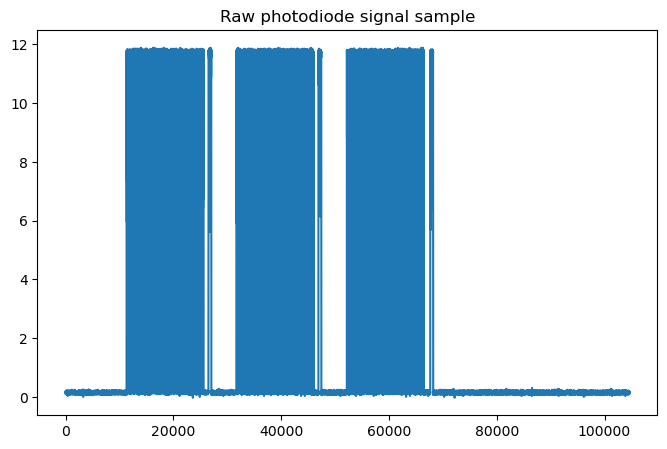

phd_1_65_17 Processing complete.
phd_2_140_17 Processing complete.
phd_1_68_17 Processing complete.
phd_0_50_17 Processing complete.
phd_2_90_17 Processing complete.
phd_0_40_17 Processing complete.
phd_1_200_17 Processing complete.
phd_2_80_17 Processing complete.
phd_0_60_17 Processing complete.
phd_0_55_17 Processing complete.
phd_2_130_17 Processing complete.
phd_1_180_17 Processing complete.
phd_0_45_17 Processing complete.
phd_2_120_17 Processing complete.
phd_1_190_17 Processing complete.


Text(0.5, 1.0, 'Image sample from photodiode after data transmission')

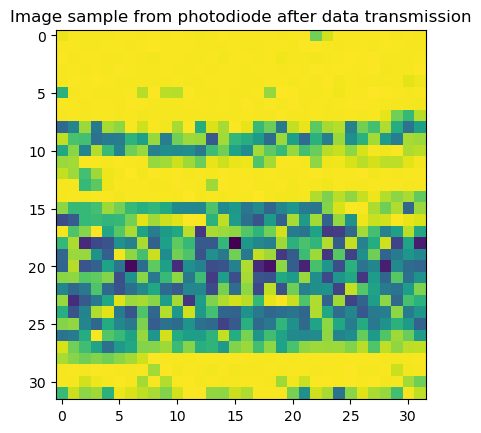

In [2]:
import os
from scipy.io import loadmat
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display


data_dict = {}
directory_path = "../Examples/3. Advanced Topics/3.3. Sensor Fusion Processing/data/photodiode"

for filename in os.listdir(directory_path):
    if filename.endswith('.mat'):
        file_path = os.path.join(directory_path, filename)
        mat_data = loadmat(file_path)
        
        data_name = os.path.splitext(filename)[0]
        print(data_name+' is loaded')
        data_dict[data_name] = mat_data

x = list(data_dict.keys())[0]
y = list(data_dict[x].keys())[3]

plt.figure(figsize=(8,5),dpi=100)
plt.plot(data_dict[x][y])
plt.title("Raw photodiode signal sample")
plt.show()

for j in range(len(data_dict.keys())):
    
    filename = list(data_dict.keys())[j]

    parts = filename.split('_')
    phd_grade = int(parts[1]) 
    phd_num = int(parts[2])
    
    filtered_data = []
    data_all = []
    for m in range(1,18):
        x = data_dict[filename]['cDAQ1Mod4ai'+str(m)]
        y = x[x>2]
        filtered_data.append(y)

    # folder = save_folder + str(phd_grade)
    n = 32  # Size of each image

    for i in range(1, 18):  # based on each layer, 17 layers in total
        data = filtered_data[i-1]
        N = len(data)
        W = n * n  # Window size
        hd = 10 * 10000 // 520  # Sliding step size
        hdcs = (N - W) // hd + 1  # Number of sliding steps

        for k in range(1, hdcs + 1):
            one_data = data[(k-1) * hd: (k-1) * hd + W]
            # Normalize and scale the data to 0-255
            one_data = np.round((one_data - np.min(one_data)) / (np.max(one_data) - np.min(one_data)) * 255).astype(np.uint8)
            # Reshape the image
            one_data = one_data.reshape((n, n)) 
            
            data_all.append(one_data)
            # # Save the image
            # image_filename = f'p_{phd_num}_{i}_{k}.png'
            # image_path = os.path.join(folder, image_filename)
            # Image.fromarray(one_data).save(image_path)

    print(filename, "Processing complete.")

data_sample = np.array(data_all[0])

plt.imshow(data_sample)
plt.title('Image sample from photodiode after data transmission')

##### **Microphone raw data preprocessing and Signal-to-image Mapping**

This is a sample code for collecting microphone raw data and data transmission.

##### **Press ▶️ to read the microphone raw data and convert it to image-based data.**

mcp_1_200_17 is loaded
mcp_0_45_17 is loaded
mcp_0_55_17 is loaded
mcp_2_140_17 is loaded
mcp_0_60_17 is loaded
mcp_2_120_17 is loaded
mcp_1_190_17 is loaded
mcp_2_80_17 is loaded
mcp_0_40_17 is loaded
mcp_2_90_17 is loaded
mcp_0_50_17 is loaded
mcp_1_65_17 is loaded
mcp_1_68_17 is loaded
mcp_2_130_17 is loaded
mcp_1_180_17 is loaded


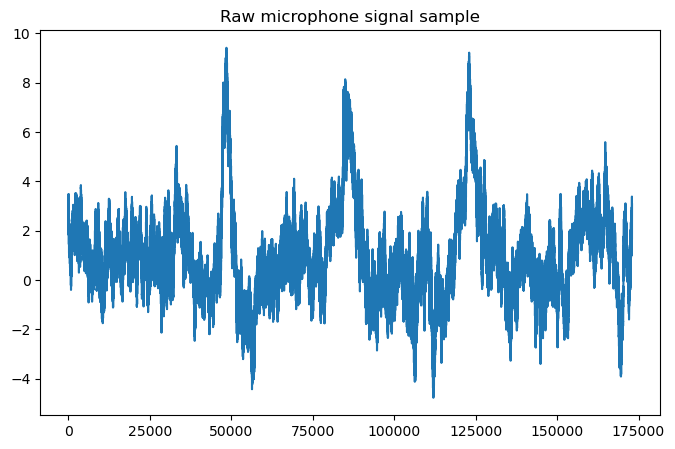

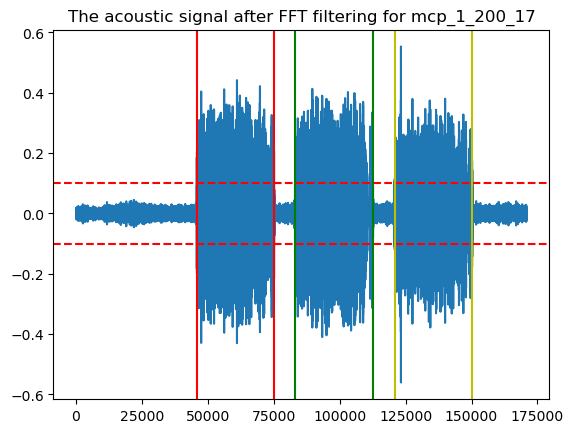

mcp_1_200_17 Processing complete.
mcp_0_45_17 Processing complete.
mcp_0_55_17 Processing complete.
mcp_2_140_17 Processing complete.
mcp_0_60_17 Processing complete.
mcp_2_120_17 Processing complete.
mcp_1_190_17 Processing complete.
mcp_2_80_17 Processing complete.
mcp_0_40_17 Processing complete.
mcp_2_90_17 Processing complete.
mcp_0_50_17 Processing complete.
mcp_1_65_17 Processing complete.
mcp_1_68_17 Processing complete.
mcp_2_130_17 Processing complete.
mcp_1_180_17 Processing complete.


Text(0.5, 1.0, 'Image sample from microphone after data transmission')

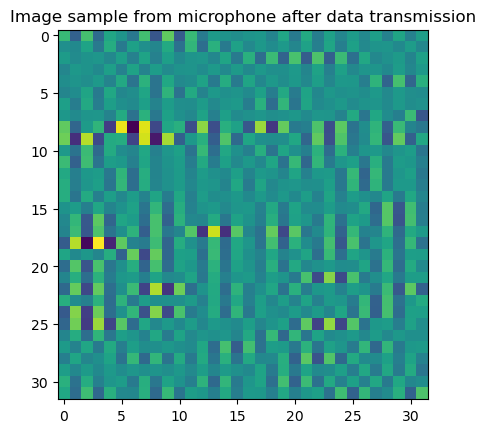

In [3]:
import os
from scipy.io import loadmat
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display

data_dict = {}
directory_path = "../Examples/3. Advanced Topics/3.3. Sensor Fusion Processing/data/microphone"

for filename in os.listdir(directory_path):
    if filename.endswith('.mat'):
        file_path = os.path.join(directory_path, filename)
        mat_data = loadmat(file_path)
        
        data_name = os.path.splitext(filename)[0]
        print(data_name+' is loaded')
        data_dict[data_name] = mat_data

x = list(data_dict.keys())[0]
y = list(data_dict[x].keys())[3]

plt.figure(figsize=(8,5),dpi=100)
plt.plot(data_dict[x][y])
plt.title("Raw microphone signal sample")
plt.show()


for i in range(len(data_dict.keys())):
    filename = list(data_dict.keys())[i]
    parts = filename.split('_')
    mcp_grade = int(parts[1]) 
    mcp_num = int(parts[2])
    
    filtered_data = []
    data_all = []
    for j in range(1,18):
        x = data_dict[filename]['cDAQ1Mod2ai'+str(j)]
#         print(x.shape)

        data = x

        data_1 = data.reshape(len(data),)
        N = len(data)
        fs = 10000  # Sampling frequency
        t = np.arange(1, N+1)  # Sampling moments

        # FFT of the data
        data_fft = np.fft.fft(data_1)
        df = fs / N  # Frequency sampling interval
        data_f = np.arange(0, N) * df

        # Find the indices where frequency is less than 4000 Hz
        id0 = np.where(data_f < 4000)[0]
        id0_len = len(id0)

        # Filtering to make the low frequency part as 0
        data_fft[id0] = 0
        data_fft[-id0_len+1:] = 0

        # Inverse FFT after filtering
        data_ifft = np.real(np.fft.ifft(data_fft))
        
        data_ifft = data_ifft[1000:-1000]
        
        indices = np.where(data_ifft > 0.1)[0]
        first_index = indices[0]
        last_index = indices[-1]
        
        first_third_index = int((last_index - first_index)/3) + first_index
        second_third_index = int(2*(last_index - first_index)/3) + first_index

        first_valid_indices = indices[indices < first_third_index]
        first_valid_indice = first_valid_indices[-1]
        
        second_valid_indices_start = indices[indices > first_third_index]
        second_valid_indice_start = second_valid_indices_start[0]
        second_valid_indices_end = indices[indices < second_third_index]
        second_valid_indice_end = second_valid_indices_end[-1]
        
        third_valid_indices = indices[indices > second_third_index]
        third_valid_indice = third_valid_indices[0]

        if (j == 1) and (i==0):
            # Plot the result
            plt.plot(data_ifft)
            plt.title("The acoustic signal after FFT filtering for "+filename)
            plt.axhline(0.1,color = 'r',linestyle='--')
            plt.axhline(-0.1,color = 'r',linestyle='--')
            plt.axvline(first_index,color = 'r')
            plt.axvline(first_valid_indice,color = 'r')
            plt.axvline(second_valid_indice_start,color = 'g')
            plt.axvline(second_valid_indice_end,color = 'g')
            plt.axvline(third_valid_indice,color = 'y')
            plt.axvline(last_index,color = 'y')
            
            plt.show()
        
        y = np.concatenate([data_ifft[first_index:first_valid_indice],
                            data_ifft[second_valid_indice_start:second_valid_indice_end],
                            data_ifft[third_valid_indice:last_index]])
#         print(y.shape)
        filtered_data.append(y)
       
    # folder = save_folder + str(mcp_grade)
    n = 32  # Size of each image

    for m in range(1, 18):  # based on each layer, 17 layers in total
        data = filtered_data[m-1]
        N = len(data)
        W = n * n  # Window size
        hd = 10 * 10000 // 520  # Sliding step size
        hdcs = (N - W) // hd + 1  # Number of sliding steps

        for k in range(1, hdcs + 1):
            one_data = data[(k-1) * hd: (k-1) * hd + W]
            # Normalize and scale the data to 0-255
            one_data = np.round((one_data - np.min(one_data)) / (np.max(one_data) - np.min(one_data)) * 255).astype(np.uint8)
            # Reshape the image
            one_data = one_data.reshape((n, n)) 
            
            data_all.append(one_data)
            # # Save the image
            # image_filename = f'p_{mcp_num}_{m}_{k}.png'
            # image_path = os.path.join(folder, image_filename)
            # Image.fromarray(one_data).save(image_path)
            
    print(filename, "Processing complete.")

data_sample = np.array(data_all[0])

plt.imshow(data_sample)
plt.title('Image sample from microphone after data transmission')

### <font color = '#646464'>6.2.3 Physical to Virtual</font>

For selective laser melting (SLM), the **physical** domain consists of the manufacturing process itself, where metal powder is selectively melted layer by layer to create a final component. However, due to process variability, ensuring consistent quality remains a significant challenge.

The **virtual** domain represents the digital modeling and monitoring of the SLM process, where sensor data is collected, processed, and analyzed to predict and control manufacturing quality. By bridging the physical and virtual worlds, we can achieve real-time insights and adaptive process control.

To accomplish this transformation, an off-axis monitoring system captures physical process signatures using a microphone and a photodiode. These 1D acoustic and optical signals are then virtually processed by converting them into 2D image representations, incorporating laser scanning data. A convolutional neural network (CNN) extracts and fuses features from both sensors, enabling accurate in-situ quality assessment. This data-driven approach enhances process understanding and improves the reliability of SLM production.

In [ ]:
import time
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import scipy.io as sio
from sklearn.model_selection import train_test_split
from PIL import Image
import pywt
from ipywidgets import interact, IntSlider
import ipywidgets as widgets
import warnings


all_path_microphone = []
signal_microphone = os.listdir("../Examples/3. Advanced Topics/3.3. Sensor Fusion Processing/data/image_data/microphone")
signal_microphone = signal_microphone[1:]
for f, fsignal in enumerate(signal_microphone):
    filepath = "../Examples/3. Advanced Topics/3.3. Sensor Fusion Processing/data/image_data/microphone" + "/" + fsignal
    filename = os.listdir(filepath)
    for fname in filename:
        ffpath = filepath + "/" + fname
        path = [f, ffpath]
        all_path_microphone.append(path)
# print(len(all_path_microphone))

def display_image_mcp(index):
    img_path = all_path_microphone[index][1]
    img = cv2.imread(img_path, 0)  

    plt.figure(figsize=(10, 6))
    plt.imshow(img, cmap='gray')
    plt.axis('off')  # Hide the axis
    plt.show()

interact(display_image_mcp, index=IntSlider(min=0, max=len(all_path_microphone)-1, step=1, value=0,description='Microphone'))



all_path_photodiode = []
signal_photodiode = os.listdir("../Examples/3. Advanced Topics/3.3. Sensor Fusion Processing/data/image_data/photodiode")
signal_photodiode = [x for x in signal_photodiode if x != '.DS_Store']

for f, fsignal in enumerate(signal_photodiode):
    filepath = os.path.join("../Examples/3. Advanced Topics/3.3. Sensor Fusion Processing/data/image_data/photodiode", fsignal)
    filename = os.listdir(filepath)
    # Additional check for .DS_Store inside subdirectories
    filename = [file for file in filename if file != '.DS_Store']
    for fname in filename:
        ffpath = os.path.join(filepath, fname)
        path = [f, ffpath]
        all_path_photodiode.append(path)

# all_path_photodiode = []
# signal_photodiode = os.listdir("../image_data/Photodiode")
# signal_photodiode = signal_photodiode[1:]
# for f, fsignal in enumerate(signal_photodiode):
#     filepath = "../image_data/Photodiode" + "/" + fsignal
#     filename = os.listdir(filepath)
#     for fname in filename:
#         ffpath = filepath + "/" + fname
#         path = [f, ffpath]
#         all_path_photodiode.append(path)
# # print(len(all_path_photodiode))

def display_image_phd(index):
    img_path = all_path_photodiode[index][1]
    img = cv2.imread(img_path, 0)  

    plt.figure(figsize=(10, 6))
    plt.imshow(img, cmap='gray')
    plt.axis('off')  # Hide the axis
    plt.show()
    
interact(display_image_phd, index=IntSlider(min=0, max=len(all_path_photodiode)-1, step=1, value=0,description='Photodiode'))


i=0
data_x1_list = []
data_x2_list = []
data_y1_list = []
data_y2_list = []

for item1, item2 in zip(all_path_microphone,all_path_photodiode):
    # print(item[0],item[1]) # 0 E:\ml_datasets\zhoucheng_data\0\0_1.png
    if item1[0] == item2[0]:
        img1=cv2.imread(item1[1],0)    
        img2=cv2.imread(item2[1],0)  
        
        arr1 = np.asarray(img1, dtype="float32")
        data_x1_list.append(arr1)
        
        arr2 = np.asarray(img2, dtype="float32")
        data_x2_list.append(arr2)
        
        i += 1
        data_y1_list.append(item1[0])
        data_y2_list.append(item2[0])

data_x1 = np.stack(data_x1_list, axis=0)[:, np.newaxis, :, :]
data_y1 = np.stack(data_y1_list, axis=0)
data_x2 = np.stack(data_x2_list, axis=0)[:, np.newaxis, :, :]
data_y2 = np.stack(data_y2_list, axis=0)

# print(data_x1.shape)
# print(data_y1.shape)
# print(data_x2.shape)
# print(data_y2.shape)

data_x1 = data_x1 / 255
data_x2 = data_x2 / 255
data_y1 = np.asarray(data_y1)
data_y2 = np.asarray(data_y2)

data_x1 = torch.from_numpy(data_x1)
data_y1 = torch.from_numpy(data_y1)
data_y1 = data_y1.long()

X1_train, X1_test, Y1_train, Y1_test = train_test_split(data_x1,
                                                    data_y1,
                                                    test_size=0.2,
                                                    random_state=999,
                                                    stratify=data_y1)
data_x2 = torch.from_numpy(data_x2)
data_y2 = torch.from_numpy(data_y2)
data_y2 = data_y2.long()

X2_train, X2_test, Y2_train, Y2_test = train_test_split(data_x2,
                                                    data_y2,
                                                    test_size=0.2,
                                                    random_state=999,
                                                    stratify=data_y2)


data1 = Data.TensorDataset(X1_train, X2_train, Y1_train)
data2 = Data.TensorDataset(X1_test, X2_test, Y1_test)
train_loader = Data.DataLoader(data1, batch_size=24,shuffle=True)
valid_loader = Data.DataLoader(data2, batch_size=24)
# print(len(data1))
# print(len(data2))

print('The sensor data is loaded')

##### **Model training**

In [ ]:
import torch
import torch.utils.data as Data
import torchvision
import torch.nn as nn
from torchvision import datasets,transforms,models
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torch.onnx
from tqdm import tqdm


class CNN_original(nn.Module):
    def __init__(self):
        super(CNN_original, self).__init__()  
        self.conv1 = nn.Sequential(
            # [1,64,64]
            nn.Conv2d(
                in_channels=1,    
                out_channels=16,  
                kernel_size=5,    
                stride=1,         
                padding=2,        
            ),
            # [16,64,64] 
            nn.MaxPool2d(kernel_size=2)   # [16,32,32] 
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,   
                out_channels=32,
                kernel_size=5,
                stride=1,
                padding=2
            ),
            # [32, 32, 32] 
            nn.MaxPool2d(kernel_size=2)  # [32,16,16] 
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,    
                out_channels=64,
                kernel_size=5,
                stride=1,
                padding=2
            ),
            # [64, 16, 16]
            nn.MaxPool2d(kernel_size=2)  # [64,8,8]
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,    
                out_channels=64,
                kernel_size=5,
                stride=1,
                padding=2
            ),
            # [64, 8, 8] 
            nn.MaxPool2d(kernel_size=2)  # [64,4,4] 
        )
            
        
        self.output = nn.Sequential(
            nn.Linear(in_features=64*2*2*2, out_features=128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=128, out_features=3)
        )
    

    def forward(self, x1, x2):           # [64×64×1]
        x1 = self.conv1(x1)           # [64×64×16]
        x1 = self.conv2(x1)           # [64×64×16]
        
        x2 = self.conv1(x2)           # [64×64×16]
        x2 = self.conv2(x2)           # [64×64×16] 
           
        
        x = torch.cat((x1,x2),3)

        x = self.conv3(x)
        x = self.conv4(x)
        
        x = x.view(x.size(0), -1)   
               
        output = self.output(x)     
        return output

model = CNN_original()

class CNN(nn.Module):
    def __init__(self, conv_params):
        super(CNN, self).__init__()
        # Unpacking parameters for each layer
        c1_out, c1_kernel, c1_stride, c1_padding = conv_params['conv1']
        c2_out, c2_kernel, c2_stride, c2_padding = conv_params['conv2']
        c3_out, c3_kernel, c3_stride, c3_padding = conv_params['conv3']
        c4_out, c4_kernel, c4_stride, c4_padding = conv_params['conv4']

        # Define the layers using the unpacked parameters
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, c1_out, c1_kernel, c1_stride, c1_padding),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(c1_out, c2_out, c2_kernel, c2_stride, c2_padding),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(c2_out, c3_out, c3_kernel, c3_stride, c3_padding),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(c3_out, c4_out, c4_kernel, c4_stride, c4_padding),
            nn.MaxPool2d(kernel_size=2)
        )
        self.output = nn.Sequential(
            nn.Linear(c4_out * 4 * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 3)
        )

    def forward(self, x1, x2):
        x1 = self.conv1(x1)
        x1 = self.conv2(x1)
        
        x2 = self.conv1(x2)
        x2 = self.conv2(x2)
        
        x = torch.cat((x1, x2), 3)
        x = self.conv3(x)
        x = self.conv4(x)
        
        x = x.view(x.size(0), -1)
        return self.output(x)


# Function to create a slider with customized width
def create_custom_slider(description, value, min, max, step):
    return widgets.IntSlider(
        value=value,
        min=min,
        max=max,
        step=step,
        description=description,
        style={'description_width': 'initial'},  # This allows the description to take as much space as it needs
        layout=widgets.Layout(width='50%')  # Adjust the width of the slider itself
    )

# Example usage in a model parameter context
def create_param_sliders():
    params = {
        'conv1': [16, 5, 1, 2],  # example values: out_channels, kernel_size, stride, padding
        'conv2': [32, 5, 1, 2],
        'conv3': [64, 5, 1, 2],
        'conv4': [64, 5, 1, 2]
    }
    sliders = {}
    for layer, param in params.items():
        sliders[layer] = [
            create_custom_slider(f'{layer} out_channels', param[0], 16, 128, 16),
            create_custom_slider(f'{layer} kernel_size', param[1], 3, 7, 1),
            create_custom_slider(f'{layer} stride', param[2], 1, 3, 1),
            create_custom_slider(f'{layer} padding', param[3], 0, 4, 1)
        ]
    return sliders

sliders = create_param_sliders()
ui = widgets.VBox([widgets.VBox(s) for s in sliders.values()])
display(ui)

def on_button_clicked(b):
    conv_params = {k: [s.value for s in v] for k, v in sliders.items()}
    global model_1
    model_1 = CNN(conv_params)
    print(model_1)
    
button = widgets.Button(description="Update Model")
button.on_click(on_button_clicked)
display(button)

def confusion_matrix(labels, preds, conf_matrix):
    for p, t in zip(labels, preds):
        conf_matrix[p, t] += 1
    return conf_matrix



summary(model, input_size=[(1, 32, 32), (1, 32, 32)])  # Specify the input size of the network
# writer = SummaryWriter('runs/model_visualization')
# dummy_input1 = torch.randn(1, 1, 32, 32)
# dummy_input2 = torch.randn(1, 1, 32, 32)
# writer.add_graph(model, (dummy_input1, dummy_input2))
# writer.close()
# torch.onnx.export(model, (dummy_input1, dummy_input2), "model.onnx")
# !netron model.onnx



loss_f = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 30
Train_epoch, Test_epoch, Train_accuracy, Test_accuracy, Loss = [], [], [], [], []
Train_time, Test_time = [], []
time0 = time.time()
Predict_label, True_label = [], []

for epoch in range(epochs):
    time1 = time.time()
    Train_epoch.append(epoch + 1)
    running_loss, running_correct = 0, 0
    print("Epoch {}/{}".format(epoch + 1, epochs))
    print("-" * 10)

    # Wrap train_loader with tqdm for a progress bar
    for data in tqdm(train_loader, desc="Training"):
        X1_train, X2_train, Y_train = data
        # Assume model and data are on the same device, add .to(device) if needed
        y_pred = model(X1_train, X2_train)
        loss = loss_f(y_pred, Y_train)
        pred = torch.max(y_pred, 1)[1]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_correct += torch.sum(pred == Y_train).item()

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = running_correct / len(train_loader.dataset) *100
    print(f"Train Loss: {train_loss:.4f}, Train ACC: {train_acc:.4f}%")

    Train_time.append(time.time() - time1)
    Loss.append(train_loss)
    Train_accuracy.append(train_acc * 100)

    # Validation loop with tqdm
    test_loss, test_correct = 0, 0
    conf_matrix = torch.zeros(3, 3)
    for data in tqdm(valid_loader, desc="Validation"):
        X1_test, X2_test, Y_test = data
        outputs = model(X1_test, X2_test)
        pred = torch.max(outputs, 1)[1]
        loss = loss_f(outputs, Y_test)
        
        if epoch == epochs-1:
            Predict_label.append(pred.numpy())
            True_label.append(Y_test.numpy())
            conf_matrix = confusion_matrix(Y_test, pred, conf_matrix)
            
        test_loss += loss.item()
        test_correct += torch.sum(pred == Y_test).item()

    test_loss /= len(valid_loader.dataset)
    test_accuracy = test_correct / len(valid_loader.dataset) *100
    print(f"Valid Loss: {test_loss:.4f}, Valid ACC: {test_accuracy:.4f}%")

    Test_accuracy.append(test_accuracy)
    Test_time.append(time.time() - time1)

# # Save results to files and print the confusion matrix
# np.savetxt('CNN1-train_time_two_sensor_feature_micpho1_32.txt', Train_time, fmt="%.4f")
# np.savetxt('CNN1-test_time_two_sensor_feature_micpho1_32.txt', Test_time, fmt="%.4f")
# save_fn = 'CNN1_two_sensor_feature_micpho1_32.mat'
# sio.savemat(save_fn, {'train_epoch': Train_epoch, 'train_accuracy': Train_accuracy,
#                               'test_epoch': Test_epoch, 'test_accuracy': Test_accuracy,
#                               'train_loss': Loss, 
#                               'predict_label': Predict_label, 
#                               'true_label': True_label})
print(conf_matrix)


import seaborn as sn
import itertools
import pandas as pd

conf_matrix=conf_matrix.numpy()
conf_matrix=conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix = np.around(conf_matrix, decimals=4)

plt.rc('font',family='Times New Roman',size=16)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
df_cm = pd.DataFrame(conf_matrix,
                     index = ["Low quality","Medium quality","High quality"],
                     columns = ["Low quality","Medium quality","High quality"])

plt.figure(figsize = (8,6))
sn.heatmap(df_cm, annot=True,annot_kws={"size": 24},cmap="Blues",fmt='.4f')
plt.gca().set_title('Confusion matrix',fontsize=24)
plt.gca().set_xlabel('Predict label',fontsize=24)
plt.gca().set_ylabel('True label',fontsize=24)
#plt.gca().xaxis.set_ticks_position('none') 
#plt.gca().yaxis.set_ticks_position('none')
plt.gca().set_yticklabels(plt.gca().get_yticklabels(), rotation=0)
plt.grid(True, which='minor', linewidth=0.8 , linestyle='-')
plt.subplots_adjust(top = 0.99, bottom = 0.12, right = 1.02, left = 0.12, hspace = 0, wspace = 0) #调整图像边缘
plt.margins(0,0)
plt.show()

##### **Sample output**

<img src="Module 6 Content/confusion_matrix.png" alt="Sample Image" width="50%">

### <font color = '#646464'>6.2.4 Virtual to Physical</font>
As we described in the Green belt level, the manufacturing process can adjust some manufacturing parameters to improve the quality of the manufactured part using control algorithms based on the damage diagnostics results of the digital model.

### <center>[◀︎ Module 5](Module5.ipynb)     [🏠 Home](../../welcomePage.ipynb)     [Module 7 ▶︎](Module7.ipynb)</center>